In [1]:
# Import necessary libraries for data manipulation, visualization, and model building
import pandas as pd   # For handling tabular data
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score   # For model evaluation
from sklearn.model_selection import train_test_split   # For splitting data into training and testing sets

In [2]:
# Load the dataset into a DataFrame
df = pd.read_csv('malicious_phish.csv')  # Load data from CSV file containing URL information

# Print basic dataset information
print(df.shape)  # Display the shape of the dataset (rows, columns)
df.head()  # Display the first few rows of the dataset

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [3]:
df.type.value_counts()   # Count occurrences of each type (label) in the target column

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

FEATURE ENGINEERING

In [4]:
# Reference: Fritz and Fritz (2023). A Practical Guide to Feature Engineering in Python - Fritz ai. [online] Fritz ai. Available at: https://fritz.ai/feature-engineering-in-python/ [Accessed 27 Jan. 2025].
# Import libraries for URL parsing and feature extraction
from urllib.parse import urlparse   # For extracting components from URLs
import re   # For working with regular expressions
from tld import get_tld   # For extracting the top-level domain (TLD) of URLs

# Reference: GeeksforGeeks (2018). Program to convert IP address to hexadecimal. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/program-convert-ip-address-hexadecimal/.
# Reference: Rashid, M. (2024). IP Address Format: Everything You Need To Know. [online] GeoPlugin - Resources -. Available at: https://www.geoplugin.com/resources/ip-address-format-everything-you-need-to-know/.
# Define a function to check for the presence of an IP address in a URL
def contains_ip_address(link):
    ip_pattern = re.search(
        r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
        r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
        r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)|'
        r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', link)   # Match IPv4, IPv6, or hexadecimal IP patterns
    return 1 if ip_pattern else 0   # Return 1 if an IP address is found, otherwise 0

# Apply the function to the 'url' column
df['ip_present'] = df['url'].apply(lambda x: contains_ip_address(x))

# Define a function to check if the URL contains abnormal patterns (e.g., hostname repetition)
def is_abnormal_url(link):
    host_name = str(urlparse(link).hostname)   # Extract hostname from the URL
    return 1 if re.search(host_name, link) else 0   # Return 1 if the hostname repeats in the URL

# Apply the abnormal URL detection function
df['abnormal_link'] = df['url'].apply(lambda x: is_abnormal_url(x))

# Generate various URL-based features
# Count the number of dots in a URL
df['dot_count'] = df['url'].apply(lambda x: x.count('.'))

# Count 'www' occurrences
df['www_count'] = df['url'].apply(lambda x: x.count('www'))

# Count '@' in URL
df['atrate_count'] = df['url'].apply(lambda x: x.count('@'))

# Count directories
df['dir_count'] = df['url'].apply(lambda x: urlparse(x).path.count('/'))

# Count embedded domains
df['embed_count'] = df['url'].apply(lambda x: urlparse(x).path.count('//'))

# Gererated using ai, Prompt used: Write a Python function `check_short_url` that checks if a given URL is a shortened URL. The function should return `1` if the URL is shortened (using common URL shorteners like bit.ly, goo.gl, etc.), and `0` if it is not. Use regular expressions to detect shortened URLs.
# Define a function to check for shortened URLs
def check_short_url(link):
    short_patterns = (
        r'bit\.ly|goo\.gl|shorte\.st|x\.co|ow\.ly|t\.co|tinyurl|is\.gd|tr\.im|cli\.gs|'
        r'qr\.net|db\.tt|tinyurl\.com|adf\.ly|cur\.lv|bit\.do'
    )   # Common URL shorteners
    return 1 if re.search(short_patterns, link) else 0   # Return 1 if a shortened URL is detected

# Apply the shortened URL detection function
df['shortened_url'] = df['url'].apply(lambda x: check_short_url(x))

# Count occurrences of 'https', 'http', '%', '?', '-', '='
df['https_count'] = df['url'].apply(lambda x: x.count('https'))
df['http_count'] = df['url'].apply(lambda x: x.count('http'))
df['percent_count'] = df['url'].apply(lambda x: x.count('%'))
df['ques_count'] = df['url'].apply(lambda x: x.count('?'))
df['hyphen_count'] = df['url'].apply(lambda x: x.count('-'))
df['equal_count'] = df['url'].apply(lambda x: x.count('='))

# Calculate URL length
df['url_len'] = df['url'].apply(lambda x: len(str(x)))

# Calculate hostname length
df['host_len'] = df['url'].apply(lambda x: len(urlparse(x).netloc))

# Define a function to detect suspicious words in URLs
def detect_suspicious_words(link):
    suspicious_keywords = (
        r'PayPal|login|signin|bank|account|update|free|lucky|service|bonus|webscr'
    )   # Common phishing-related keywords
    return 1 if re.search(suspicious_keywords, link) else 0

# Apply the suspicious word detection function
df['sus_words'] = df['url'].apply(lambda x: detect_suspicious_words(x))

# Count numeric and alphabetic characters in URLs
df['digit_count'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x))
df['letter_count'] = df['url'].apply(lambda x: sum(c.isalpha() for c in x))

# Define a function to calculate the length of the first directory in the URL path
def first_dir_length(link):
    path = urlparse(link).path   # Extract the URL path
    try:
        return len(path.split('/')[1])
    except IndexError:
        return 0   # Return 0 if no directory is present

# Apply the first directory length calculation
df['first_dir_len'] = df['url'].apply(lambda x: first_dir_length(x))

# Extract and calculate the length of the top-level domain (TLD)
df['tld'] = df['url'].apply(lambda x: get_tld(x, fail_silently=True))   # Extract TLD
df['tld_len'] = df['tld'].apply(lambda x: len(x) if x else -1)   # Length of TLD (-1 if not found)

# Remove 'tld' column after processing
df.drop(columns=['tld'], inplace=True)

# Display the updated DataFrame structure and value counts for the target variable
print(df.columns)   # Print column names
print(df['type'].value_counts())   # Count occurrences of each target type
df.head()   # Display the first few rows of the updated DataFrame

Index(['url', 'type', 'ip_present', 'abnormal_link', 'dot_count', 'www_count',
       'atrate_count', 'dir_count', 'embed_count', 'shortened_url',
       'https_count', 'http_count', 'percent_count', 'ques_count',
       'hyphen_count', 'equal_count', 'url_len', 'host_len', 'sus_words',
       'digit_count', 'letter_count', 'first_dir_len', 'tld_len'],
      dtype='object')
type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


,url,type,ip_present,abnormal_link,dot_count,www_count,atrate_count,dir_count,embed_count,shortened_url,...,ques_count,hyphen_count,equal_count,url_len,host_len,sus_words,digit_count,letter_count,first_dir_len,tld_len
0,br-icloud.com.br,phishing,0,0,2,0,0,0,0,0,...,0,1,0,16,0,0,0,13,0,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,2,0,0,2,0,0,...,0,0,0,35,0,0,1,29,5,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,2,0,0,3,0,0,...,0,0,0,31,0,0,1,25,7,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,3,1,0,1,0,0,...,1,1,4,88,21,0,7,63,9,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,2,0,0,1,0,0,...,1,1,3,235,23,0,22,199,9,3


EDA (Exploratory Data Analysis)

Data-Overview

In [5]:
# Display basic information about the DataFrame such as the number of non-null values, data types, and memory usage
print(df.info())

# Summary statistics
print(df.describe())

# Check if there are any missing values in the dataset and show the count of missing values for each column
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   url            651191 non-null  object
 1   type           651191 non-null  object
 2   ip_present     651191 non-null  int64 
 3   abnormal_link  651191 non-null  int64 
 4   dot_count      651191 non-null  int64 
 5   www_count      651191 non-null  int64 
 6   atrate_count   651191 non-null  int64 
 7   dir_count      651191 non-null  int64 
 8   embed_count    651191 non-null  int64 
 9   shortened_url  651191 non-null  int64 
 10  https_count    651191 non-null  int64 
 11  http_count     651191 non-null  int64 
 12  percent_count  651191 non-null  int64 
 13  ques_count     651191 non-null  int64 
 14  hyphen_count   651191 non-null  int64 
 15  equal_count    651191 non-null  int64 
 16  url_len        651191 non-null  int64 
 17  host_len       651191 non-null  int64 
 18  sus_

Univariate Analysis

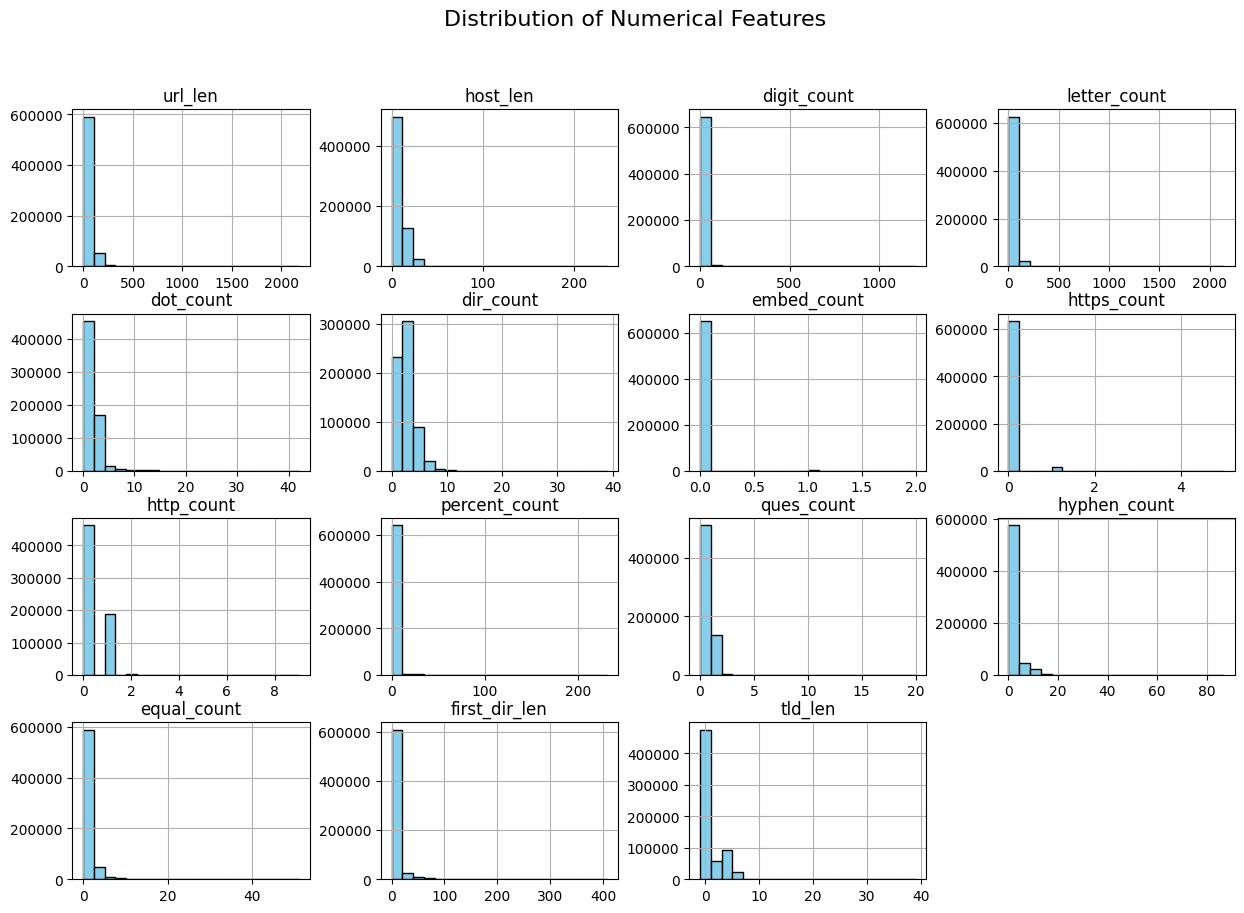

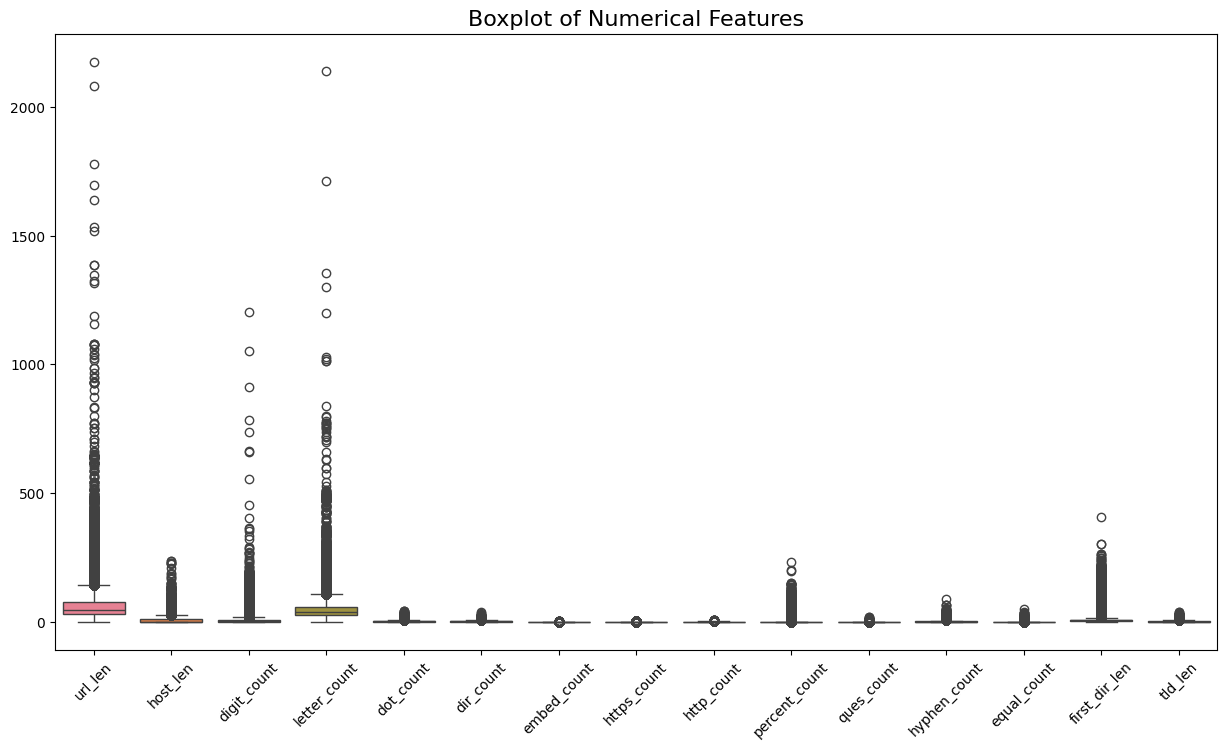

In [6]:
# (a) Numerical Features
# Import the necessary libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ai assistance, Prompt used: Define a list of numerical feature columns and plot their distributions with histograms and boxplots.
# Define a list of numerical feature columns in the dataset
numerical_features = [
    'url_len', 'host_len', 'digit_count', 'letter_count', 
    'dot_count', 'dir_count', 'embed_count', 
    'https_count', 'http_count', 'percent_count', 
    'ques_count', 'hyphen_count', 'equal_count', 'first_dir_len', 'tld_len'
]

# Plot histograms for all numerical features to visualize their distributions
df[numerical_features].hist(bins=20, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.show()

# Plot a boxplot for each numerical feature to visualize outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numerical_features])
plt.title('Boxplot of Numerical Features', fontsize=16)
plt.xticks(rotation=45)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2429355696.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature], palette='viridis')


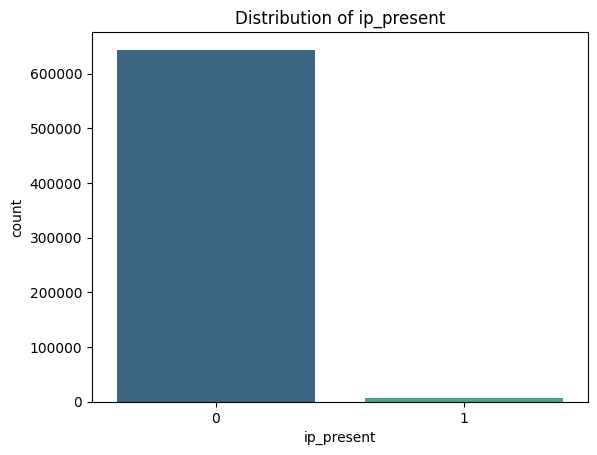

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2429355696.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature], palette='viridis')


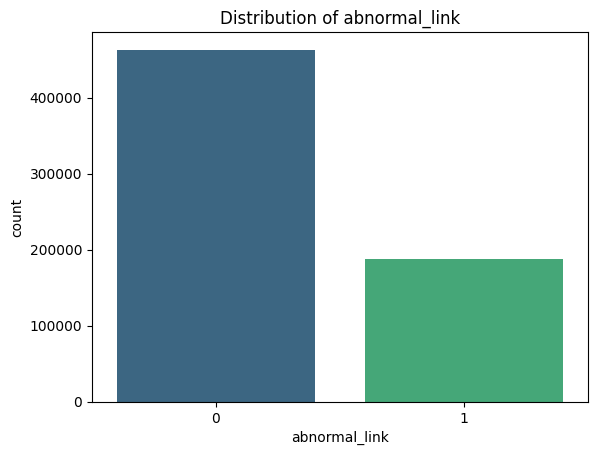

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2429355696.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature], palette='viridis')


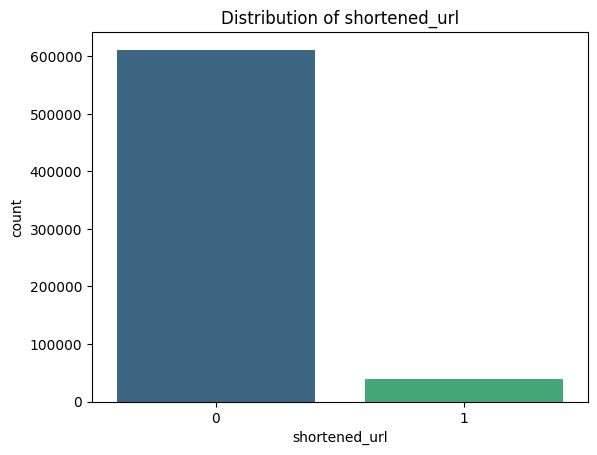

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2429355696.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature], palette='viridis')


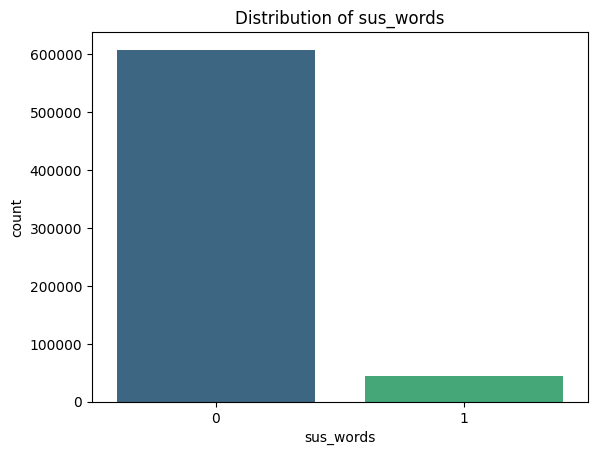

In [7]:
# (b) Categorical Features
# Define a list of categorical feature columns in the dataset
categorical_features = ['ip_present', 'abnormal_link', 'shortened_url', 'sus_words']

# Loop through each categorical feature and plot a count plot to visualize the distribution of values
for feature in categorical_features:
    sns.countplot(x=df[feature], palette='viridis')
    plt.title(f'Distribution of {feature}')
    plt.show()

Bivariate Analysis

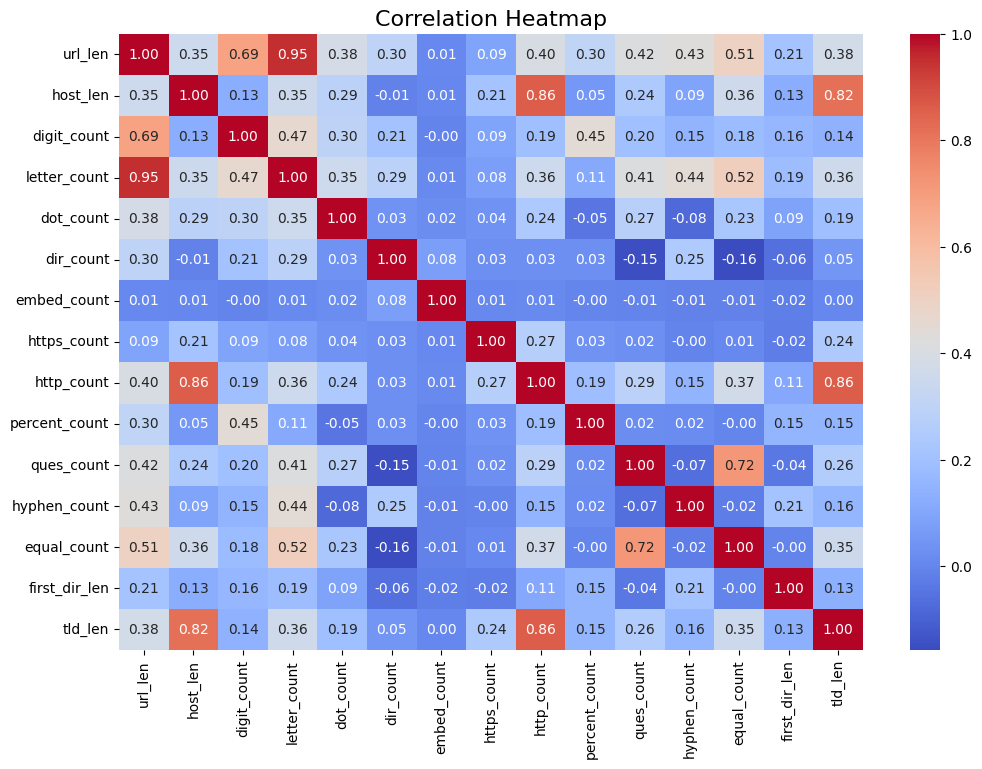

In [8]:
'''explore the relationship between two variables in a dataset. 
The goal is to understand how one variable (the independent variable) influences or is related to another variable (the dependent variable).
 It helps identify patterns, correlations, trends, and potential cause-effect relationships between variables.'''
# (a) Correlation Analysis
# Correlation heatmap
# Plot a heatmap to visualize the correlation between numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


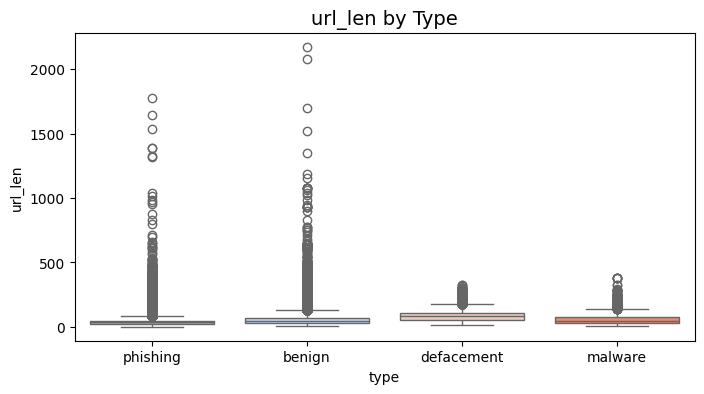

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


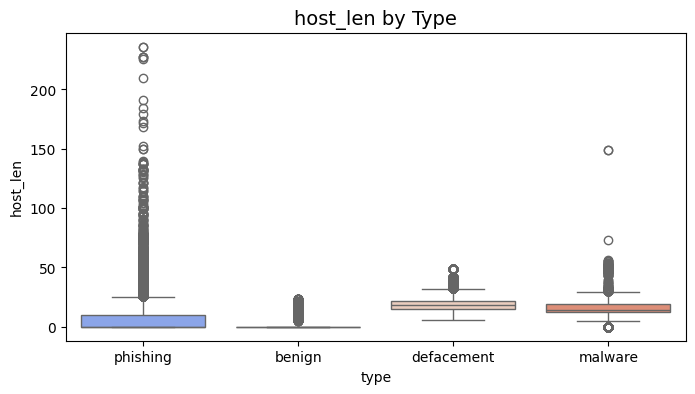

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


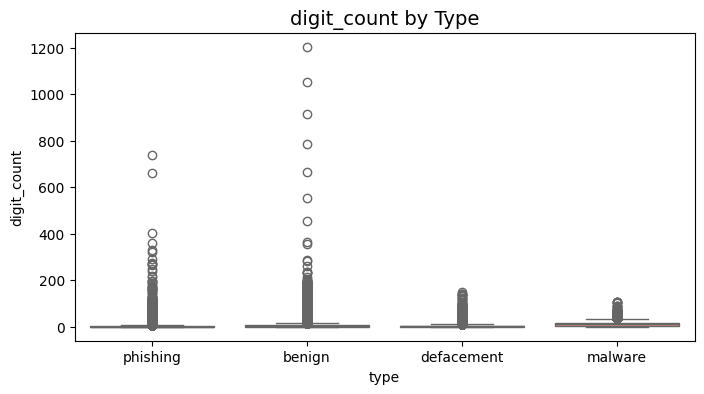

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


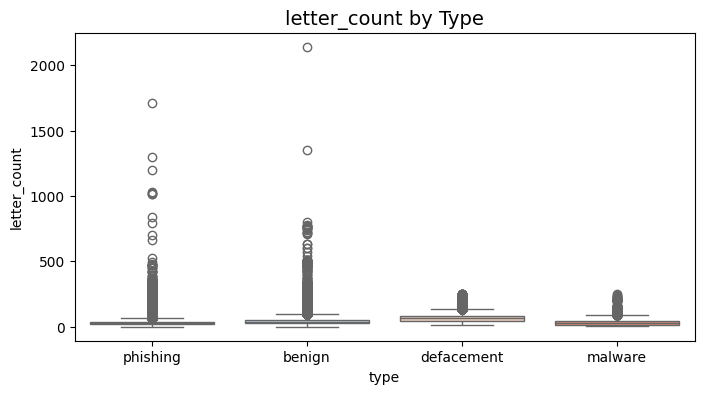

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


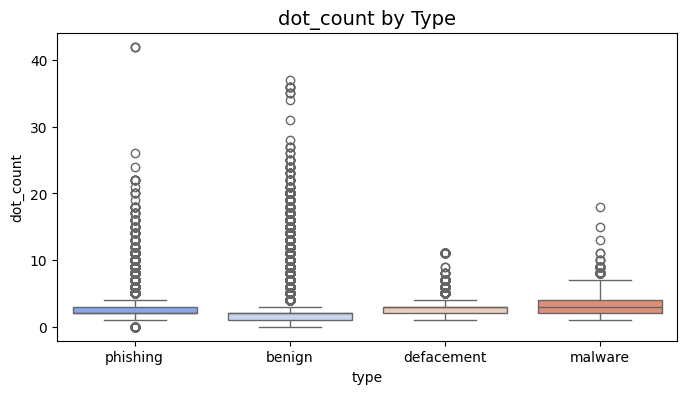

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


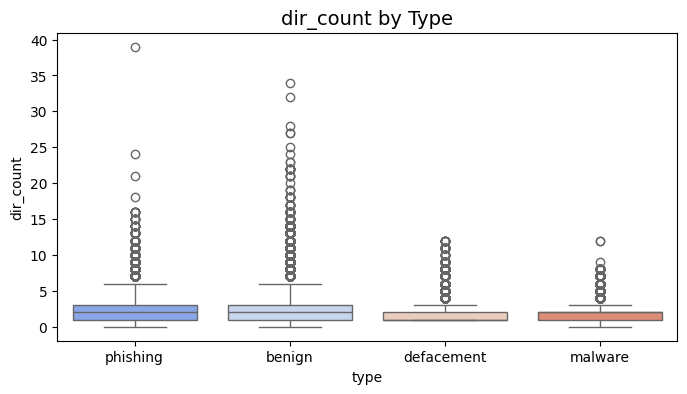

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


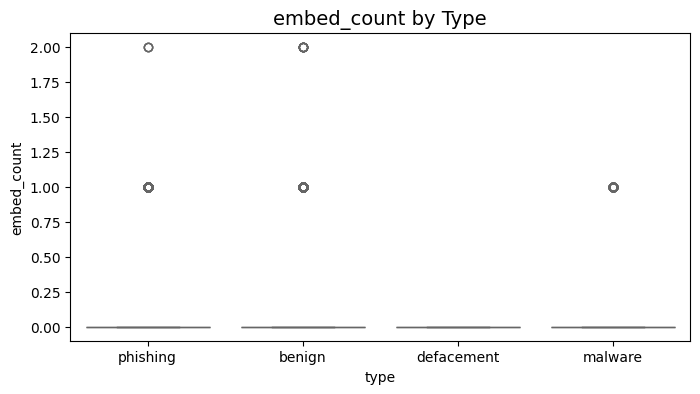

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


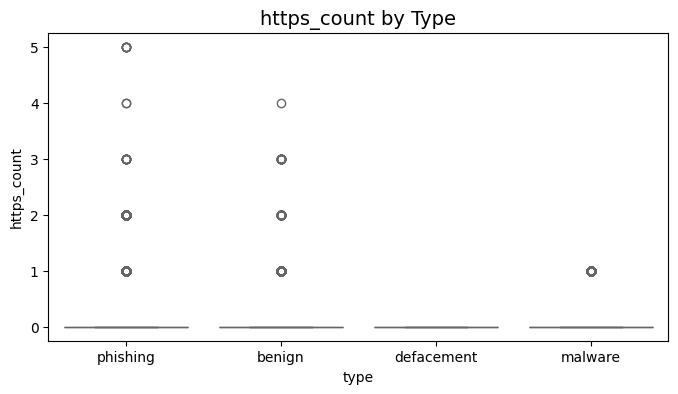

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


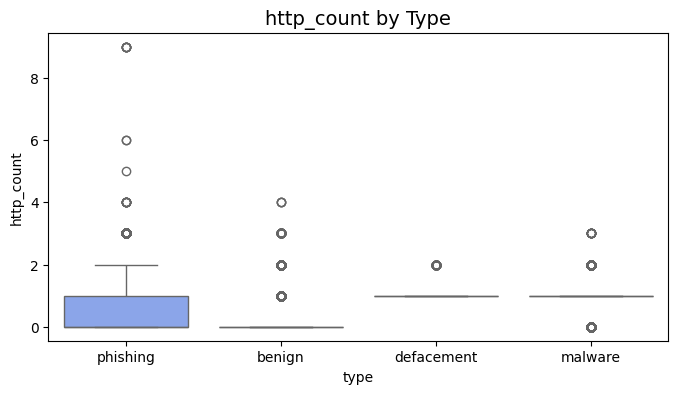

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


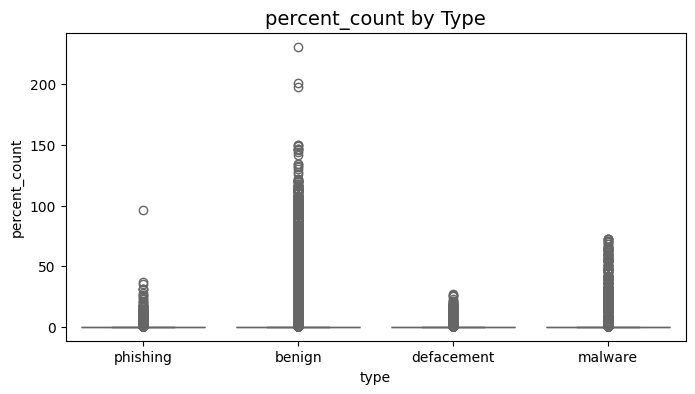

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


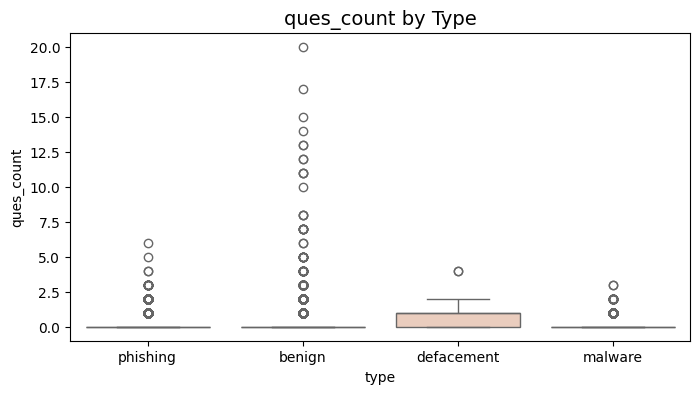

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


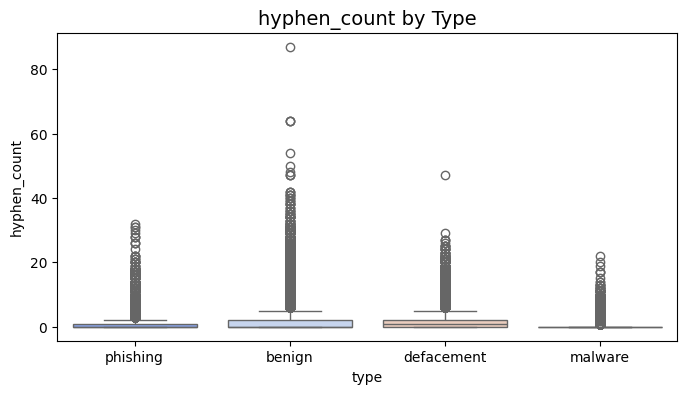

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


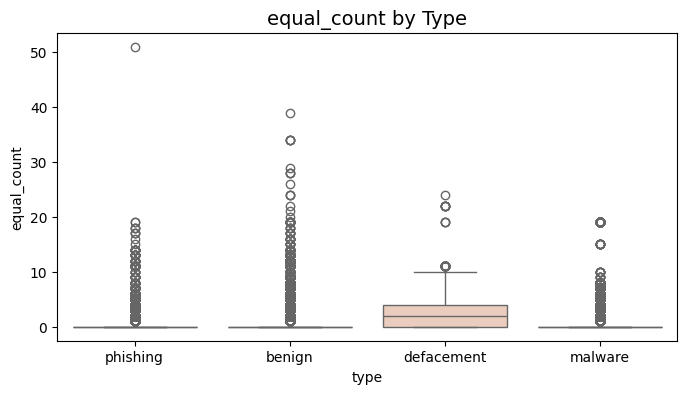

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


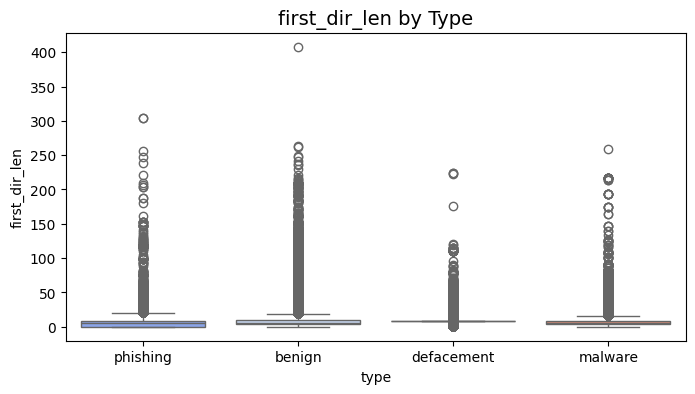

C:\Users\user\AppData\Local\Temp\ipykernel_27816\2017055833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')


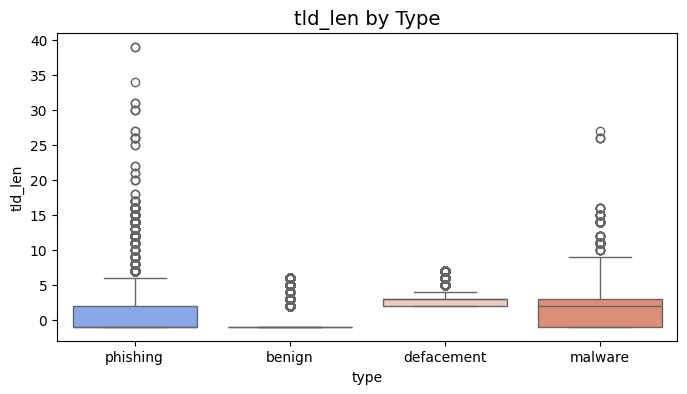

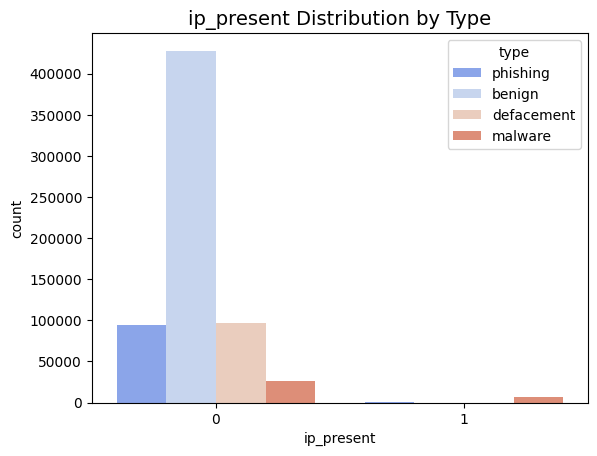

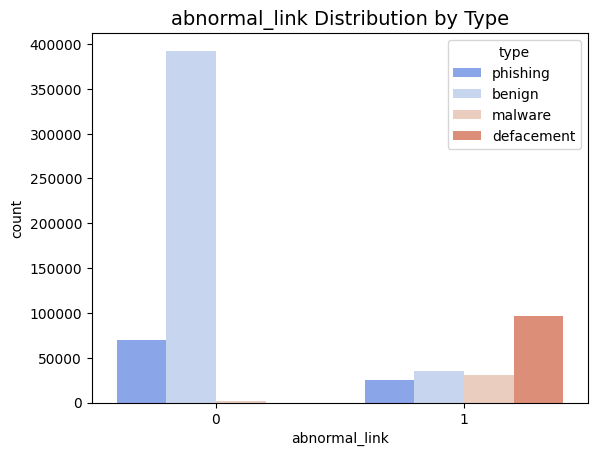

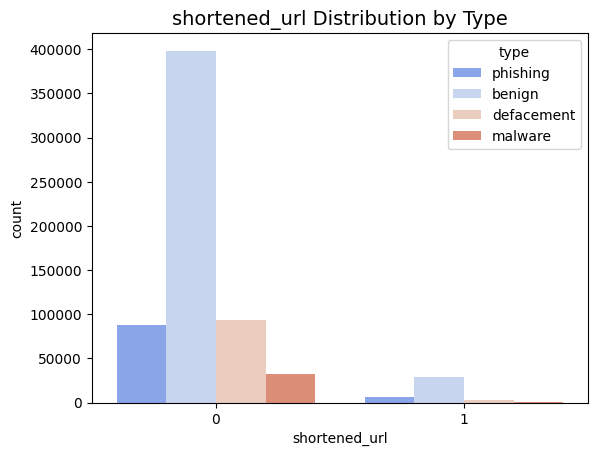

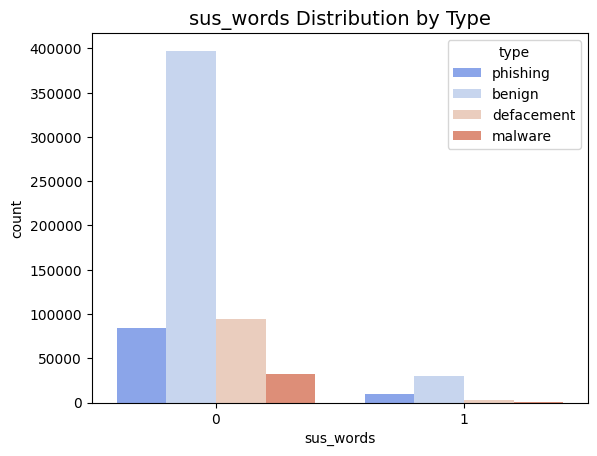

In [9]:
# (b) Relationship with Target Variable
# Loop through each numerical feature and plot a boxplot to compare distributions based on the target variable
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df['type'], y=df[feature], palette='coolwarm')
    plt.title(f'{feature} by Type', fontsize=14)
    plt.show()

# Loop through each categorical feature and plot a countplot to compare distributions by the target variable
for feature in categorical_features:
    sns.countplot(x=df[feature], hue=df['type'], palette='coolwarm')
    plt.title(f'{feature} Distribution by Type', fontsize=14)
    plt.show()

Outlier Detection

Number of outliers per feature:
 url_len         11749
host_len         6016
digit_count     11193
letter_count     9525
dtype: int64


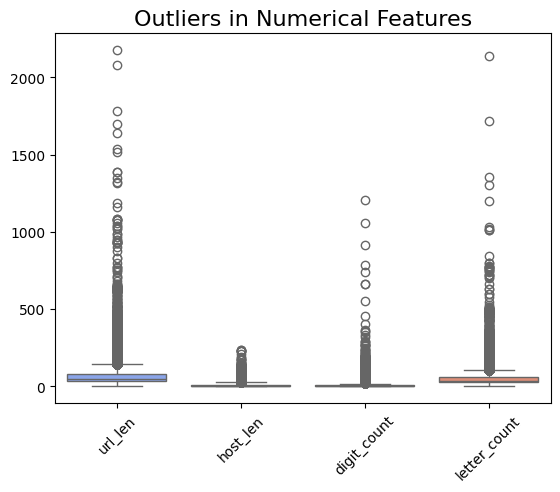

In [10]:
# Import zscore function from scipy to detect outliers
from scipy.stats import zscore

# Calculate the z-scores for the selected features to detect outliers
outlier_features = ['url_len', 'host_len', 'digit_count', 'letter_count']
z_scores = df[outlier_features].apply(zscore)

# Identify outliers
outliers = (z_scores.abs() > 3).sum()
print("Number of outliers per feature:\n", outliers)

# Visualize outliers in the numerical features using a boxplot
sns.boxplot(data=df[outlier_features], palette='coolwarm')
plt.title('Outliers in Numerical Features', fontsize=16)
plt.xticks(rotation=45)
plt.show()

IMPLEMENTATION OF Logistic Regression

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 87.17%

Classification Report:
              precision    recall  f1-score   support

      benign       0.89      0.97      0.93     85621
  defacement       0.85      0.94      0.89     19292
     malware       0.80      0.72      0.76      6504
    phishing       0.77      0.40      0.53     18822

    accuracy                           0.87    130239
   macro avg       0.83      0.76      0.78    130239
weighted avg       0.86      0.87      0.86    130239



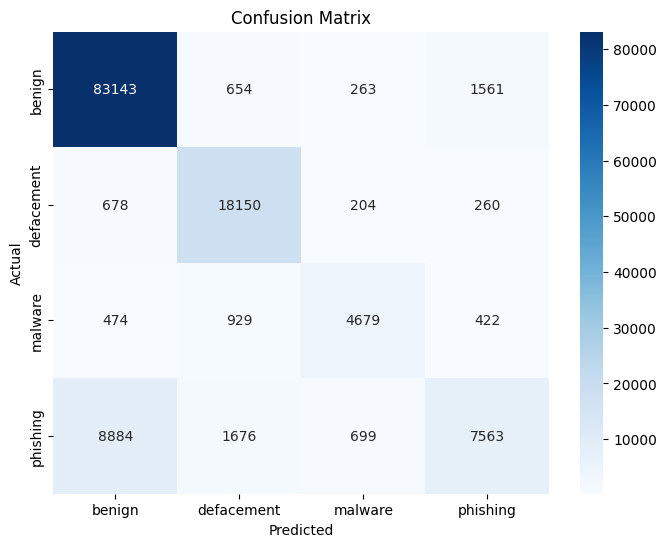

C:\Users\user\AppData\Local\Temp\ipykernel_27816\517858608.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')


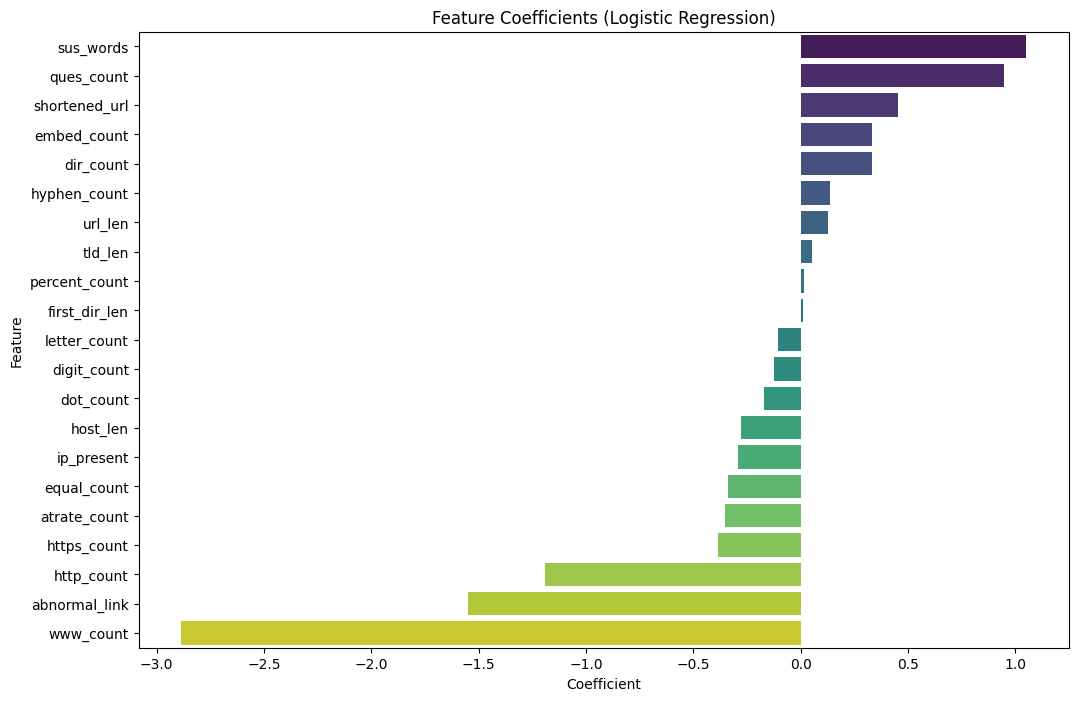

In [11]:
# Step 1: Data Preprocessing
# Import necessary libraries for model building and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode the target variable ('type') into numerical labels
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])

# Separate the features (X) from the target (y) variable
X = df.drop(columns=['url', 'type'])  # Drop 'url' column as it's not a feature for prediction
y = df['type']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Train the Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the classifier using the training data
log_reg.fit(X_train, y_train)

# Step 3: Predictions
y_pred = log_reg.predict(X_test)

# Step 4: Model Evaluation
# Import necessary evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print a detailed classification report, including precision, recall, and F1-score for each class
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Generate and plot the confusion matrix to visualize the model's performance
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 5: Coefficients Analysis
# Extract and visualize the coefficients (feature importance) from the Logistic Regression model
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg.coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients as a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')
plt.title('Feature Coefficients (Logistic Regression)')
plt.show()
